# LAB 5. Cross-Validation & Grid Search of Model Parameters

In this practical assignment, we will consolidate the understanding of Cross-Validation approach.

![](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

We also learn Stratified K-Fold Cross-Validation and Grid Search of Hyperparameters.

We'll use already familiar to you [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic). Recall, description of the fields ([see in detail](https://www.kaggle.com/c/titanic/data)):
+ **survival** -- Survival: 0 = No, 1 = Yes
+ **pclass** -- Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
+ **sex** -- Sex
+ **Age** -- Age in years
+ **sibsp** -- # of siblings / spouses aboard the Titanic
+ **parch** -- # of parents / children aboard the Titanic
+ **ticket** -- Ticket number
+ **fare** -- Passenger fare
+ **cabin** -- Cabin number
+ **embarked** -- Port of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

## Outline
Click on the links to jump to a particular section of the assignment.
- [1. Loading data](#1)
- [2. Exploring data](#2)
    - [2.1. Check missing values](#2-1)
    - [2.2. Handle missing values and feature engineering](#2-2)
    - [2.3. Selecting features](#2-3)
- [3. Build a model](#3)
- [4. Cross-validation](#4)
    - [4.1. K-fold cross-validation](#4-1)
    - [4.2. Stratified K-fold cross-validation](#4-2)
- [5. Grid search of model parameters using cross-validation](#5)
    - [5.1. GridSearchCV](#5-1)
    - [5.2. Create a submission file for the Titanic Kaggle Challenge](#5-2)
- [6. Other cross-validators](#6)
    - [6.1. Repeated K-fold cross-validation](#6-1)
    - [6.2. Leave one out cross-validation (LOOCV)](#6-2)
    - [6.3. Random permutations cross-validation a.k.a. shuffle & split](#6-3)
    - [6.4. Group K-Fold cross-validation](#6-4)
- [7. YOUR TURN](#7)
    - [7.1. One-set approach (using `train` set only)](#7-1)
    - [7.2. One-set approach + GridSearchCV](#7-2)
    - [7.3. Two-sets approach (using `train/dev` split)](#7-3)
    - [7.4. Three-sets approach (`train/dev/test` split)](#7-4)
    - [7.5. Draw your conclusions](#7-5)


## References

- [Titanic: Machine Learning from Disaster (Kaggle Challenge)](https://www.kaggle.com/c/titanic)
- [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/)
- [Understanding Cross Validation’s purpose](https://medium.com/@mtterribile/understanding-cross-validations-purpose-53490faf6a86)
- [Evaluate the Performance of Machine Learning Algorithms in Python using Resampling](https://machinelearningmastery.com/evaluate-performance-machine-learning-algorithms-python-using-resampling/)
- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)
- [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
- [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)
- [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

<a name="1"></a>
## 1. Loading data

In [ ]:
# Load useful libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('data/titanic_train_data.csv')
test = pd.read_csv('data/titanic_test_data.csv')

dataset = [train, test]

print("Shape of the train dataframe =", train.shape)
print("Shape of the test dataframe =", test.shape)

# Display examples of the train
train.head()

Shape of the train dataframe = (891, 12)
Shape of the test dataframe = (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Display examples of the test
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<a name="2"></a>
## 2. Exploring data

<a name="2-1"></a>
### 2.1. Check missing values

In [ ]:
# Check missing values in train data
print("Missing values in the training set:")
print(train.isnull().sum())
print()
print("Missing values in the test set:")
print(test.isnull().sum())

Missing values in the training set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values in the test set:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


<a name="2-2"></a>
### 2.2. Handle missing values and feature engineering

In [ ]:
for data in dataset:
    # Fill missing values of Age and Fare with median values
    data['Age'] = data['Age'].fillna(value=data['Age'].median())
    data['Fare'] = data['Fare'].fillna(value=data['Fare'].median())
    data["Embarked"] = data["Embarked"].fillna(value="S")   # because "S" is the most common port of embarkation    
    
    # Replace string values by numbers
    data["Sex"] = data["Sex"].map({"male": 1, "female": 0}).astype(int)    
    data["Embarked"] = data["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int)    
    
    # Create a new feature
    data["FamilySize"] = data["Parch"] + data["SibSp"]       

    
# Check missing Age and Fare values
print("Check missing values:")
print("  Train: Age - {}, Fare - {}".format(train.Age.isnull().sum(), train.Fare.isnull().sum()))
print("  Test : Age - {}, Fare - {}".format(test.Age.isnull().sum(), test.Fare.isnull().sum()))

Check missing values:
  Train: Age - 0, Fare - 0
  Test : Age - 0, Fare - 0


<a name="2-3"></a>
### 2.3. Selecting features

In [ ]:
# Set X and y
X = train[["Sex", "Pclass", "FamilySize", "Age", "Fare", "Embarked"]]
y = train["Survived"]

<a name="3"></a>
## 3. Build a model

As a model, let's use [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from the `sklearn`.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score


def LogisticRegressionSklearn(X, y, cv, test_size=0.3, C=1):
    """
    Build scikit-learn logistic regression model.

    Args:
        X (pd.DataFrame): input feature examples, size (n_examples, 1)
        y (pd.Series): labels, size (n_examples,)
        cv (i.e., int, CV splitter): determines the cross-validation splitting strategy
        test_size (float): proportion of the dataset to include in the test split
        C (float): inverse of regularization strength
    Returns:
        model (sklearn.linear_model): sklearn-based model
    """    

    # Split the training data
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Create a model
    model = LogisticRegression(solver='liblinear', C=C)
  
    # Obtain cross-validation scores
    results = cross_val_score(model, X_train, y_train, cv=cv)
    
    # Display cross-validation scores
    print("Cross-validation accuracies:")
    for i, acc in enumerate(results, start=1):
        print(f"{i} fold: {acc:.3f}")
    print(f"CV mean \u03BC = {results.mean():.3f} with CV standard deviation \u03C3 = {results.std():.2f}")
    print()

    # Train the model
    model.fit(X_train, y_train)
    
    # Get and display train error        
    y_train_pred = model.predict(X_train)
    print("Train accuracy: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
    print()

    # Get and display test error
    y_dev_pred = model.predict(X_dev)
    print("Dev accuracy:  {:.3f}".format(accuracy_score(y_dev, y_dev_pred)))
    
    return model

<a name="4"></a>
## 4. Cross-validation

In [ ]:
# Set the number of splits for cross-validation, i.e., K value
N_SPLITS = 5

<a name="4-1"></a>
### 4.1. K-fold cross-validation
 
[KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) cross-validator divides all the samples in `k` groups of samples, called folds. Note that [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is not affected by classes or groups.
![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

In [ ]:
from sklearn.model_selection import KFold

# Set K-fold cross-validation parameters
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Get a model with a K-fold cross-validation
model = LogisticRegressionSklearn(X, y, cv=kfold);

Cross-validation accuracies:
1 fold: 0.824
2 fold: 0.760
3 fold: 0.768
4 fold: 0.815
5 fold: 0.839
CV mean μ = 0.801 with CV standard deviation σ = 0.03

Train accuracy: 0.804

Dev accuracy:  0.802


<a name="4-2"></a>
### 4.2. Stratified K-fold cross-validation

[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) cross-validator is a variation of [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) that returns stratified folds. The folds are made by **preserving the percentage of samples for each class**.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Set Stratified K-fold cross-validation parameters
skfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Get a model with a Stratified K-fold cross-validation
LogisticRegressionSklearn(X, y, cv=skfold);

Cross-validation accuracies:
1 fold: 0.784
2 fold: 0.864
3 fold: 0.808
4 fold: 0.798
5 fold: 0.726
CV mean μ = 0.796 with CV standard deviation σ = 0.04

Train accuracy: 0.804

Dev accuracy:  0.802


<a name="5"></a>
## 5. Grid search of model parameters using cross-validation

<a name="5-1"></a>
### 5.1. GridSearchCV

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) provides exhaustive search over specified parameter values for an estimator.

[ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) returns a grid of parameters with a discrete number of values for each.

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

# Select features
selected_features = ["Sex", "Pclass", "Age"]
X = train[selected_features]
y = train["Survived"]

# Split the data
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate a model
model = LogisticRegression(solver='liblinear')

# Set a parameters grid
params = {'C': np.linspace(0.1, 2, 20),    # notice np.linspace()
          'max_iter': [50, 100, 150, 200],
          'penalty': ('l1', 'l2')
         }

# Display the current grid of parameters
print("Parameters grid:")
print(*list(ParameterGrid(params))[:10], sep="\n")
print("...........................................")

# Set a GridSearch model
grid_model = GridSearchCV(model, params, cv=N_SPLITS)  # cv: For integer/None inputs, if the estimator is a classifier
                                                       #     and y is either binary or multiclass, StratifiedKFold is used.
                                                       #     In all other cases, KFold is used.
# Train the GridSearch model
grid_model.fit(X_train, y_train)

# Get the best estimator
model = grid_model.best_estimator_ 

# Display the best estimator, score and parameters
print("Best estimator:")
print(model)
print()
print("Mean cross-validated score (of the best estimator): {:.3f}".format(grid_model.best_score_))
print()
print("Best parameters: {}".format(grid_model.best_params_))
print()

# Obtain and display test error

y_dev_pred = grid_model.predict(X_dev)
print("Dev accuracy: {:.3f}".format(accuracy_score(y_dev, y_dev_pred)))

Parameters grid:
{'C': 0.1, 'max_iter': 50, 'penalty': 'l1'}
{'C': 0.1, 'max_iter': 50, 'penalty': 'l2'}
{'C': 0.1, 'max_iter': 100, 'penalty': 'l1'}
{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}
{'C': 0.1, 'max_iter': 150, 'penalty': 'l1'}
{'C': 0.1, 'max_iter': 150, 'penalty': 'l2'}
{'C': 0.1, 'max_iter': 200, 'penalty': 'l1'}
{'C': 0.1, 'max_iter': 200, 'penalty': 'l2'}
{'C': 0.2, 'max_iter': 50, 'penalty': 'l1'}
{'C': 0.2, 'max_iter': 50, 'penalty': 'l2'}
...........................................
Best estimator:
LogisticRegression(C=0.7, max_iter=50, penalty='l1', solver='liblinear')

Mean cross-validated score (of the best estimator): 0.795

Best parameters: {'C': 0.7, 'max_iter': 50, 'penalty': 'l1'}

Dev accuracy: 0.806


<a name="5-2"></a>
### 5.2. Create a submission file for the Titanic Kaggle Challenge

In [ ]:
# Make a prediction
X_test = test[selected_features]
y_test_pred = grid_model.predict(X_test)

# Create a submission file
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": y_test_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


<a name="6"></a>
## 6. Other cross-validators

<a name="6-1"></a>
### 6.1. Repeated K-fold cross-validation

[RepeatedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) repeats K-Fold `n` times. It can be used when one requires to run KFold `n` times, producing different splits in each repetition.

<a name="6-2"></a>
### 6.2. Leave one out cross-validation (LOOCV)

[LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for `n` samples, we have `n` different training sets and `n` different tests set.

<a name="6-3"></a>
### 6.3. Random permutations cross-validation a.k.a. shuffle & split

The [ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) iterator will generate a user defined number of independent train / test dataset splits. Samples are first shuffled and then split into a pair of train and test sets. Note that it is not affected by classes or groups.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0061.png)

<a name="6-4"></a>
### 6.4. Group K-Fold cross-validation

In case we have groups of dependent samples, for example, medical data collected from multiple patients with multiple samples taken from each patient, better to use [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html). In this case we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

<a name="7"></a>
## 7. YOUR TURN

<a name="7-1"></a>
### 7.1. One-set approach (using `train` set only)

1. Using all the `train` set, select features and train the logistic regression model (try to get the highest `train` accuracy).

2. Create and submit your predictions for the [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic).

In [ ]:
# Create a model using only the train set

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
X = train.copy()
y = train.Survived

In [ ]:
X['TravelAlone'] = np.where((X["SibSp"] + X["Parch"]) > 0, 0, 1)
X['IsMinor'] = np.where(X['Age'] <= 16, 1, 0)

In [ ]:
test['TravelAlone'] = np.where((test["SibSp"] + test["Parch"]) > 0, 0, 1)
test['IsMinor'] = np.where(test['Age'] <= 16, 1, 0)

In [ ]:
cols = ["Age","Fare","TravelAlone","Pclass", "Embarked", "Sex","IsMinor"] 

In [ ]:
# # Preprocessing for numerical data
numerical_transformer =  Pipeline(steps=[
    ('norm', StandardScaler()),
    ])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, cols),
    ])

In [ ]:
model = LogisticRegression(solver='liblinear')

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

In [ ]:
clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('norm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'TravelAlone',
                                                   'Pclass', 'Embarked', 'Sex',
                                                   'IsMinor'])])),
                ('model', LogisticRegression(solver='liblinear'))])

In [ ]:
accuracy_score(y, clf.predict(X))

0.8013468013468014

In [ ]:
def save(model, name):
  pd.DataFrame({"PassengerId" : test.PassengerId,
             "Survived" : pd.Series(model.predict(test))}).to_csv(f"{name}.csv", index=False)

In [ ]:
save(clf, "71")

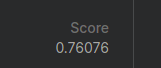

<a name="7-2"></a>
### 7.2. One-set approach + GridSearchCV

1. Using all the `train` set and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), select features and train the logistic regression model (try to get the highest mean cross-validated `train` accuracy). Tip: do not use `cv` for [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) higher than 5.

2. Submit your predictions for the [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic).

In [ ]:
# Create a model using only the train set and GridSearchCV
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__norm', 'preprocessor__num__norm__copy', 'preprocessor__num__norm__with_mean', 'preprocessor__num__norm__with_std', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

In [ ]:
params = {'model__C': np.linspace(0.1, 5, 20),    # notice np.linspace()
          'model__max_iter': [50, 100, 150, 200],
          'model__penalty': ('l1', 'l2')
         }

grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('norm',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'TravelAlone',
                                                                          'Pclass',
                                                                          'Embarked',
                                                                          'Sex',
                                                                          'IsMinor'])])),
                                       ('mo

In [ ]:
model_gs_best = grid_search.best_estimator_ 

In [ ]:
print("Mean cross-validated score (of the best estimator): {:.3f}".format(grid_search.best_score_))
print()
print("Best parameters: {}".format(grid_search.best_params_))

Mean cross-validated score (of the best estimator): 0.792

Best parameters: {'model__C': 0.1, 'model__max_iter': 50, 'model__penalty': 'l2'}


In [ ]:
accuracy_score(y, model_gs_best.predict(X))

0.7912457912457912

In [ ]:
save(model_gs_best, "72")

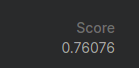

<a name="7-3"></a>
### 7.3. Two-sets approach (using `train/dev` split)

1. Split `train` into training and development sets—`train/dev`—in the ratio of 70/30 %.

2. Using `train` set and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), select features and train the logistic regression model (try to get the highest mean cross-validated `train` accuracy).

3. Check the `dev` accuracy for the synthesized model. It should be close to the mean cross-validated `train` accuracy (if it's not, go back to step 2 and redo the model, e.g., select other features).

4. Submit your predictions for the [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic).

In [ ]:
# Create a model using train/dev split and GridSearchCV

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=.3)

In [ ]:
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('norm',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'TravelAlone',
                                                                          'Pclass',
                                                                          'Embarked',
                                                                          'Sex',
                                                                          'IsMinor'])])),
                                       ('mo

In [ ]:
model_gs_best = grid_search.best_estimator_ 
model_gs_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('norm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'TravelAlone',
                                                   'Pclass', 'Embarked', 'Sex',
                                                   'IsMinor'])])),
                ('model',
                 LogisticRegression(C=0.35789473684210527, max_iter=50,
                                    solver='liblinear'))])

In [ ]:
print("Mean cross-validated score (of the best estimator): {:.3f}".format(grid_search.best_score_))

Mean cross-validated score (of the best estimator): 0.799


In [ ]:
accuracy_score(y_train, model_gs_best.predict(X_train))

0.8089887640449438

In [ ]:
accuracy_score(y_dev, model_gs_best.predict(X_dev))

0.7686567164179104

In [ ]:
save(model_gs_best, "73")

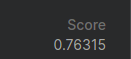

<a name="7-4"></a>
### 7.4. Three-sets approach (`train/dev/test` split)

1. Split `train` into training, development and test sets—`train/dev/test`—in the ratio of 60/20/20 %.

2. Using `train` set and [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), select features and train the logistic regression model (try to get the highest mean cross-validated `train` accuracy).

3. Check the `dev` accuracy for the synthesized model. It should be close to the mean cross-validated `train` accuracy  (if it's not, go back to step 2 and redo the model, e.g., select other features).

4. Check the `test` accuracy for the synthesized model. It should be close to the `dev` accuracy (if it's not, go back to step 2 and redo the model).

5. Submit your predictions for the [Titanic Kaggle Challenge](https://www.kaggle.com/c/titanic).

In [ ]:
# Create a model using train/dev/test split and GridSearchCV

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('norm',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'TravelAlone',
                                                                          'Pclass',
                                                                          'Embarked',
                                                                          'Sex',
                                                                          'IsMinor'])])),
                                       ('mo

In [ ]:
model_gs_best = grid_search.best_estimator_ 
model_gs_best

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('norm',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'TravelAlone',
                                                   'Pclass', 'Embarked', 'Sex',
                                                   'IsMinor'])])),
                ('model',
                 LogisticRegression(C=0.1, max_iter=50, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
print("Mean cross-validated score (of the best estimator): {:.3f}".format(grid_search.best_score_))

Mean cross-validated score (of the best estimator): 0.803


In [ ]:
accuracy_score(y_train, model_gs_best.predict(X_train))

0.8033707865168539

In [ ]:
accuracy_score(y_dev, model_gs_best.predict(X_dev))

0.7761194029850746

In [ ]:
accuracy_score(y_test, model_gs_best.predict(X_test))

0.776536312849162

In [ ]:
save(model_gs_best, "74")

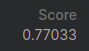

<a name="7-5"></a>
### 7.5. Draw your conclusions

Please note that although approach 6.4 is often the best one, it is not necessarily the best for this task. It largely depends on the amount of data and usefulness of the features for building a model (predicting a target parameter).

Дані завжди треба розділяти на дві або три частини:
* train/test -  в такому випадку робити кросвалідацію на трейні, а тест використовувати для перевірки генералізації моделі
* train/dev/test - в такому випадку навчати на трейні, підбирати гіперпараметри на dev, перевіряти генералізацію на тест
